In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


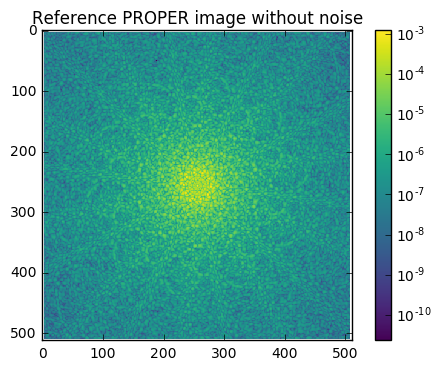

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

19031239.431


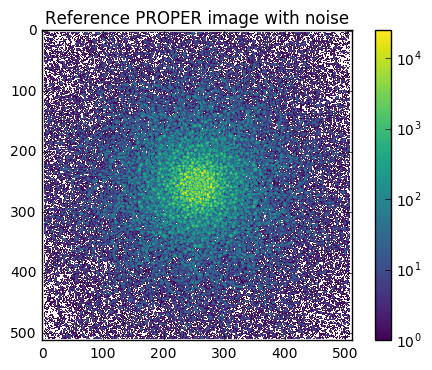

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fit by tweaking position and flux


In [8]:
# Function to generate 
errors = []
def model_err(params, view=False):
    tiltx = params[0]
    tilty = params[1]
    flux = params[2]
    settings = toliman_settings.copy()
    settings['tilt_x'] = tiltx 
    settings['tilt_y'] = tilty
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale*flux
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    errors.append((params,error))
    print('Error for offset ({:.2e},{:.2e}) and flux {:.2e}: {}% baseline '.format(tiltx, tiltx, flux, round(100.*error/min_err)))
    return error

## Optimize

### Nelder-Mead Simplex algorithm

This is a popular derivative-free multivariate minimization algorithm.

In [ ]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.1, 0.1,0.8]
opt = minimize(model_err, dir_init, method='nelder-mead')

In [11]:
print(opt)

 final_simplex: (array([[ -8.93103722e-05,   2.02935193e-06,   1.00005319e+00],
       [ -8.93147285e-05,   2.02534052e-06,   1.00005321e+00],
       [ -8.92973710e-05,   2.02005588e-06,   1.00005322e+00],
       [ -8.93058057e-05,   2.02924077e-06,   1.00005323e+00]]), array([ 18270711.61976309,  18270711.61977913,  18270711.61981203,
        18270711.61981229]))
           fun: 18270711.619763091
       message: 'Optimization terminated successfully.'
          nfev: 188
           nit: 102
        status: 0
       success: True
             x: array([ -8.93103722e-05,   2.02935193e-06,   1.00005319e+00])


In [ ]:
# How do things look now?
tiltx = opt.x[0]
tilty = opt.x[1]
flux = opt.x[2]
settings = toliman_settings.copy()
settings['tilt_x'] = tiltx 
settings['tilt_y'] = tilty
source = {
        'wavelengths': [wavelength],
        'weights': [1.],
        'settings': settings
        }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
final *= intensity_scale*flux

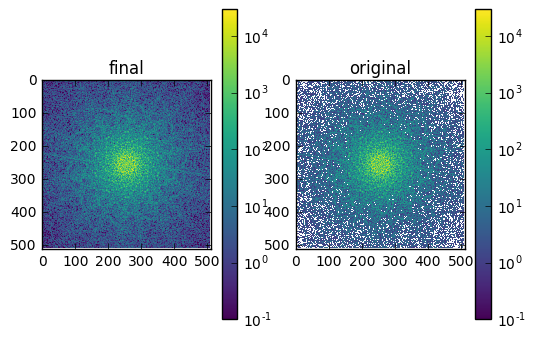

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [14]:
print("Final error {:.2e} vs. minimum bound of {:.2e} ({})".format(np.sum((detector_image - final)**2), min_err, round(100.*np.sum((detector_image - final)**2)/min_err)))

Final error 1.83e+07 vs. minimum bound of 1.83e+07 (100.0)


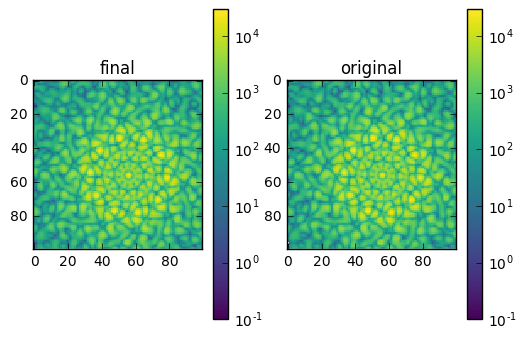

In [15]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

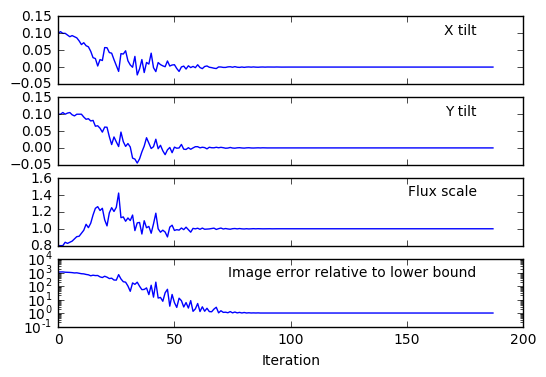

In [44]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X,Y,F,E) = zip(*[(i,dx,dy,df,e/min_err) for i,((dx,dy,df),e) in enumerate(errors)])

f, axes = plt.subplots(4, sharex=True)
axes[0].plot(I, X)
axes[0].text(.9,.9,'X tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[0].transAxes)
axes[0].locator_params(axis='y', nbins=6)
axes[1].plot(I, Y)
axes[1].text(.9,.9,'Y tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[1].transAxes)
axes[1].locator_params(axis='y', nbins=6)
axes[2].plot(I, F)
axes[2].text(.9,.9,'Flux scale',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[2].transAxes)
axes[2].locator_params(axis='y', nbins=6)
axes[3].plot(I, E)
axes[3].text(.9,.9,'Image error relative to lower bound',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[3].transAxes)
axes[3].locator_params(axis='y', nbins=6)
axes[3].set_yscale('log')
axes[3].set_xlabel('Iteration')
plt.show()

### Limited-memory BFGS algorithm

This algorithm estimates the inverse Hessian matrix, and is appropriate for smooth functions. It makes use of bounds.

In [11]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.1, 0.1,0.8]
opt = minimize(model_err, dir_init, method='L-BFGS-B',
               bounds=[(-1.0,1.0),(-1.0,1.0),(0.5,1.5)])

Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 103212.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 103212.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 103212.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 103212.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 1.50e+00: 737786.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 1.50e+00: 737786.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 1.50e+00: 737786.0% baseline 
Error for offset (-1.00e+00,-1.00e+00) and flux 1.50e+00: 737786.0% baseline 
Error for offset (-1.40e-01,-1.40e-01) and flux 9.53e-01: 187171.0% baseline 
Error for offset (-1.40e-01,-1.40e-01) and flux 9.53e-01: 187171.0% baseline 
Error for offset (-1.40e-01,-1.40e-01) and flux 9.53e-01: 187171.0% baseline 
Error for offset (-1.40e-01,-1.40e-01) and flux 9.53e-01: 187171.0% baseline 
Error for offset (3.66e-03,3.66e-03) and flux 8.61e-01: 7271.0% baseline

In [12]:
print(opt)

      fun: 19028304.258865092
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.96046448, -3.7252903 ,  0.74505806])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 9
   status: 0
  success: True
        x: array([  3.87126359e-05,  -2.03625229e-06,   9.99870712e-01])


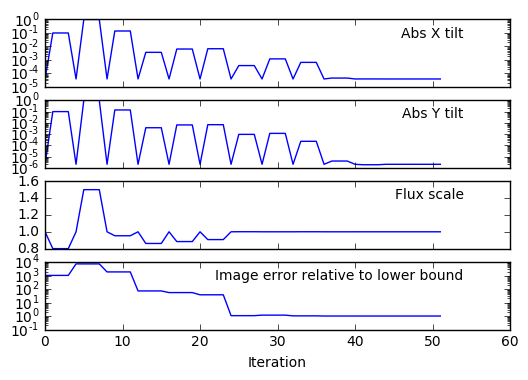

In [15]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X,Y,F,E) = zip(*[(i,abs(dx),abs(dy),df,e/min_err) for i,((dx,dy,df),e) in enumerate(errors)])

f, axes = plt.subplots(4, sharex=True)
axes[0].plot(I, X)
axes[0].text(.9,.9,'Abs X tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[0].transAxes)
axes[0].locator_params(axis='y', nbins=6)
axes[0].set_yscale('log')
axes[1].plot(I, Y)
axes[1].text(.9,.9,'Abs Y tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[1].transAxes)
axes[1].locator_params(axis='y', nbins=6)
axes[1].set_yscale('log')
axes[2].plot(I, F)
axes[2].text(.9,.9,'Flux scale',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[2].transAxes)
axes[2].locator_params(axis='y', nbins=6)
axes[3].plot(I, E)
axes[3].text(.9,.9,'Image error relative to lower bound',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[3].transAxes)
axes[3].locator_params(axis='y', nbins=6)
axes[3].set_yscale('log')
axes[3].set_xlabel('Iteration')
plt.show()